In [1]:
%run SAT_help_functions.ipynb

In [2]:
def get_ks_data(data_dir, sample_size, correct, corrects, cond, conds, rt):

    ks_cor_s, ks_cor_a, ks_err_s, ks_err_a = [],[],[],[]
    for i in range(sample_size):
        #print(i)
        path = os.path.join(data_dir+str(i+1)+".csv")
        df = pd.read_csv(path, sep = ",")
        #print(df)
        df = df[df[rt]<5]
        
        df_s = df[df[cond] == conds[0]]
        df_cor_s = df_s[df_s[correct]==corrects[0]]
        df_err_s = df_s[df_s[correct]==corrects[1]]

        df_a = df[df[cond] == conds[1]]
        df_cor_a = df_a[df_a[correct]==corrects[0]]
        df_err_a = df_a[df_a[correct]==corrects[1]]

        
        ks_cor_s.append(get_ks_stat(df_cor_s, eval_model = False, rt = rt))
        ks_err_s.append(get_ks_stat(df_err_s, eval_model = False, rt = rt))
        ks_cor_a.append(get_ks_stat(df_cor_a, eval_model = False, rt = rt))
        ks_err_a.append(get_ks_stat(df_err_a, eval_model = False, rt = rt))
        
        ks_data = pd.DataFrame({"cor_s":ks_cor_s,
                                "cor_a":ks_cor_a,
                                "err_s": ks_err_s,
                                'err_a': ks_err_a})
    
    return ks_data


In [3]:
def get_ks_stat(df, eval_model = True, rt = "RT"):
    #print(len(df["RT"]))
    if eval_model:
        if len(df[rt])<1000:
            return 0
    else:
        if len(df[rt])<10:
            return 0
    
    normal_samp = np.random.normal(loc=np.mean(df[rt]), scale=np.std(df[rt]), size=len(df[rt]))
    ks = scipy.stats.kstest(df[0:1000][rt], normal_samp)[0]
    return ks

def get_ks_DDM_matched(params_all, sample_size, cond, conds, RT = "Time", T_dur=5):

    ks_all = pd.DataFrame()

    for i in range(sample_size):
        params = np.array(params_all)[i,1:7]
        
        Vspeed,Vacc, Bspeed,Bacc,tSpeed,tAcc = params[0],params[1],params[2],params[3],params[4],params[5]

        model = Model(name='Simple model (fitted)',
                          drift=DriftConstantSpeedAcc(Vspeed=Vspeed, Vacc=Vacc), 
                          noise=NoiseConstant(noise=1),
                          bound=BoundSpeedAcc(Bspeed=Bspeed,Bacc=Bacc),
                          overlay=NondecisionSpeedAcc(tSpeed=tSpeed,tAcc=tAcc),
                          dx=.001, dt=.001, T_dur=T_dur)
        sol_s = model.solve({cond:conds[0]})
        samp_s = sol_s.resample(100000)
        data_s = samp_s.to_pandas_dataframe(drop_undecided = True)

        sol_a = model.solve({cond:conds[1]})
        samp_a = sol_a.resample(100000)
        data_a = samp_a.to_pandas_dataframe(drop_undecided = True)
        
        path = os.path.join(data_dir+str(i+1)+".csv")
        df = pd.read_csv(path, sep = ",")
        #print(df)
        df = df[df[RT]<5]
        
        df_s = df[df[cond] == conds[0]]
        n_cor_s = len(df_s[df_s[correct]==corrects[0]])
        n_err_s = len(df_s[df_s[correct]==corrects[1]])

        df_a = df[df[cond] == conds[1]]
        n_cor_a = len(df_a[df_a[correct]==corrects[0]])
        n_err_a = len(df_a[df_a[correct]==corrects[1]])

        #print(data_s[data_s['choice']==1][0:n_cor_s])
        ks_cor_s = get_ks_stat(data_s[data_s['choice']==1][0:n_cor_s],eval_model = False)
        ks_err_s = get_ks_stat(data_s[data_s['choice']==0][0:n_err_s],eval_model = False)
        ks_cor_a = get_ks_stat(data_a[data_a['choice']==1][0:n_cor_a],eval_model = False)
        ks_err_a = get_ks_stat(data_a[data_a['choice']==0][0:n_err_a],eval_model = False)

        ks = pd.DataFrame({"cor_s":[ks_cor_s], "err_s": [ks_err_s], "cor_a":[ks_cor_a],'err_a': [ks_err_a]})
        ks["Participant"] = i

        ks_all = pd.concat((ks_all,ks))
        
    return ks_all

def get_ks_OUM_matched(params_all, sample_size, cond, conds, RT = "Time", T_dur=5):

    ks_all = pd.DataFrame()

    for i in range(sample_size):
        params = np.array(params_all)[i,1:8]
        
        Vspeed,Vacc, Kspeed,Kacc,B,tSpeed,tAcc = params[0],params[1],params[2],params[3],params[4],params[5],params[6]

        model = Model(name='Simple model (fitted)',
                          drift=DriftBothSpeedAcc(Vspeed=Vspeed, Vacc=Vacc, Kspeed=Kspeed, Kacc=Kacc),                              
                          noise=NoiseConstant(noise=1),
                          bound=BoundConstant(B=B),
                          overlay=NondecisionSpeedAcc(tSpeed=tSpeed,tAcc=tAcc),
                          dx=.001, dt=.001, T_dur=T_dur)
        sol_s = model.solve({cond:conds[0]})
        samp_s = sol_s.resample(100000)
        data_s = samp_s.to_pandas_dataframe(drop_undecided = True)

        sol_a = model.solve({cond:conds[1]})
        samp_a = sol_a.resample(100000)
        data_a = samp_a.to_pandas_dataframe(drop_undecided = True)
        
        path = os.path.join(data_dir+str(i+1)+".csv")
        df = pd.read_csv(path, sep = ",")
        #print(df)
        df = df[df[RT]<5]
        
        df_s = df[df[cond] == conds[0]]
        n_cor_s = len(df_s[df_s[correct]==corrects[0]])
        n_err_s = len(df_s[df_s[correct]==corrects[1]])

        df_a = df[df[cond] == conds[1]]
        n_cor_a = len(df_a[df_a[correct]==corrects[0]])
        n_err_a = len(df_a[df_a[correct]==corrects[1]])

        #print(data_s[data_s['choice']==1][0:n_cor_s])
        ks_cor_s = get_ks_stat(data_s[data_s['choice']==1][0:n_cor_s],eval_model = False)
        ks_err_s = get_ks_stat(data_s[data_s['choice']==0][0:n_err_s],eval_model = False)
        ks_cor_a = get_ks_stat(data_a[data_a['choice']==1][0:n_cor_a],eval_model = False)
        ks_err_a = get_ks_stat(data_a[data_a['choice']==0][0:n_err_a],eval_model = False)

        ks = pd.DataFrame({"cor_s":[ks_cor_s], "err_s": [ks_err_s], "cor_a":[ks_cor_a],'err_a': [ks_err_a]})
        ks["Participant"] = i

        ks_all = pd.concat((ks_all,ks))
        
    return ks_all

In [4]:
def plot_normality_correct(ks_DDM,ks_OUM, ax=None):
    if ax is None:
        ax = plt.gca()
    
    ax.scatter(ks_DDM["cor_s"], ks_OUM["cor_s"],c = [[1,1,1]], edgecolors = "#1F77B4", alpha = 0.7, label = "Speed")
    ran = np.arange(0,max(ks_DDM["cor_s"].max(axis=None),ks_OUM["cor_s"].max(axis=None))+0.02,0.0001)
    ax.plot(ran,ran,c = "black")
    
    ax.scatter(ks_DDM["cor_a"], ks_OUM["cor_a"],c = [[1,1,1]], edgecolors = "#FF7F0E", alpha = 0.7, label = "Speed")
    ran = np.arange(0,max(ks_DDM["cor_a"].max(axis=None),ks_OUM["cor_a"].max(axis=None))+0.02,0.0001)
    ax.plot(ran,ran,c = "black")
    ax.set_title("Correct Choices")
    ax.set_xlabel("K-S Statistic of DDM")
    ax.set_ylabel("K-S Statistic of OUM")
    
    return ax

def plot_normality_error(ks_DDM,ks_OUM, ax=None):
    if ax is None:
        ax = plt.gca()
    
    ax.scatter(ks_DDM["err_s"], ks_OUM["err_s"],c = [[1,1,1]], edgecolors = "#1F77B4", alpha = 0.7, label = "Speed")
    ran = np.arange(0,max(ks_DDM["err_s"].max(axis=None),ks_OUM["err_s"].max(axis=None))+0.02,0.0001)
    ax.plot(ran,ran,c = "black")
    
    ax.scatter(ks_DDM["err_a"], ks_OUM["err_a"],c = [[1,1,1]], edgecolors = "#FF7F0E", alpha = 0.7, label = "Speed")
    ran = np.arange(0,max(ks_DDM["err_a"].max(axis=None),ks_OUM["err_a"].max(axis=None))+0.02,0.0001)
    ax.plot(ran,ran,c = "black")
    ax.set_title("Incorrect Choices")
    ax.set_xlabel("K-S Statistic of DDM")
    #ax.set_ylabel("K-S Statistic of OUM")
    
    return ax

In [12]:
%run SAT_help_functions.ipynb



correct = 'Correct'
corrects = [1, 0]
cond = 'Cond' 
conds = ['Speed', 'Accuracy']
rt = 'Time'

In [29]:
data_dir = "/Users/wangjiashun/Desktop/Research_on_SAT/datasets/transformed/"+dataset+"/sub"


ks_data = get_ks_data(data_dir, sample_size, correct, corrects, cond, conds, rt)



model = 'DDM2v2a2ter'
params_all = pd.read_csv("Parameter Estimates/"+model+"result"+dataset+".csv")# .drop(labels=3, axis=0)
ks_DDM = get_ks_DDM_matched(params_all, sample_size, cond, conds)

model = 'OUM2v2k2ter'
params_all = pd.read_csv("Parameter Estimates/"+model+"result"+dataset+".csv")#.drop(labels=3, axis=0)
ks_OUM = get_ks_OUM_matched(params_all, sample_size, cond, conds)

ks_data.to_csv("KS_statistic/ks_data_"+dataset)
ks_DDM.to_csv("KS_statistic/ks_DDM_matched_"  +dataset)
ks_OUM.to_csv("KS_statistic/ks_OUM_matched_"  +dataset)


In [133]:
correct = 'Correct'
corrects = [True, False]
cond = 'Cond'
conds = ['Speed', 'Accuracy']
rt = 'Time'


In [67]:
pd.read_csv("KS_statistic/ks_data_Dutilh2013")

,Unnamed: 0,cor_s,cor_a,err_s,err_a
0,0,0.051056,0.082500,0.082569,0.136364
1,1,0.139130,0.168831,0.259259,0.375000
2,2,0.211538,0.200000,0.134021,0.166667
3,3,0.086420,0.178571,0.000000,0.000000
4,4,0.083333,0.125000,0.333333,0.000000
5,5,0.071942,0.087302,0.100000,0.250000
6,6,0.040080,0.208791,0.092437,0.000000
7,7,0.071429,0.121359,0.274510,0.307692
8,8,0.114094,0.195652,0.125000,0.227273
9,9,0.140741,0.093458,0.142857,0.360656


In [81]:
dataset="Dutilh2013"
sample_size = 32

In [22]:
dataset="Dutilh2019"
sample_size = 20

In [24]:
dataset="Evans2017"
sample_size = 47

In [26]:
dataset = "Lerche2017"
sample_size = 38

In [28]:
dataset="Rae2014"
sample_size = 34

In [59]:

dataset = "Wagenmakers2008"
sample_size = 16

In [60]:
Frequencies = [1,  2, 3,  4,  5,  6]
participants = [1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]

In [62]:
quantiles_data,quantiles_DDM,quantiles_OUM =[],[],[]
for freq in Frequencies:
    data_dir = "/Users/wangjiashun/Desktop/Research_on_SAT/datasets/transformed/Wagenmakers2008/dataByFreq/Freq"+str(freq)+"/sub"    

    ## data 
    quantiles_data_df = get_ks_data(data_dir, sample_size, correct, corrects, cond, conds, rt)

    ## data generated from DDM
    params_DDM = pd.read_csv("Parameter Estimates/DDM2v2a2terresult"+dataset+".csv")# .drop(labels=3, axis=0)
    quantiles_DDM_df = get_ks_DDM_matched(params_DDM, sample_size, cond, conds)

    ## data generated from OUM
    params_OUM = pd.read_csv("Parameter Estimates/OUM2v2k2terresult"+dataset+".csv")#.drop(labels=3, axis=0)
    quantiles_OUM_df = get_ks_OUM_matched(params_OUM, sample_size, cond, conds)

    quantiles_data.append(quantiles_data_df)
    quantiles_DDM.append(quantiles_DDM_df)
    quantiles_OUM.append(quantiles_OUM_df)    

In [65]:
quantiles_OUM

[      cor_s     err_s     cor_a  err_a  Participant
 0  0.154930  0.000000  0.137500      0            0
 0  0.225806  0.000000  0.174419      0            1
 0  0.157143  0.000000  0.228916      0            2
 0  0.270270  0.000000  0.240964      0            3
 0  0.253968  0.000000  0.125000      0            4
 0  0.125000  0.280000  0.102564      0            5
 0  0.227273  0.150000  0.186047      0            6
 0  0.205479  0.000000  0.255556      0            7
 0  0.136691  0.230769  0.141026      0            8
 0  0.124088  0.000000  0.193333      0            9
 0  0.187050  0.333333  0.226667      0           10
 0  0.157895  0.200000  0.099338      0           11
 0  0.187500  0.000000  0.167832      0           12
 0  0.195652  0.333333  0.173333      0           13
 0  0.203252  0.185185  0.104167      0           14
 0  0.091549  0.000000  0.145833      0           15,
       cor_s     err_s     cor_a     err_a  Participant
 0  0.147541  0.000000  0.266667  0.000000

In [5]:
def plot_09quantile_all_datasets_new(Condition, title, ax = None):
    if ax is None:
        ax = plt.gca()
    
    datasets = ["Dutilh 2013", "Dutilh 2019", "Evans 2017", "Lerche 2017", "Rae 2014", "Wagenmakers 2008"]

    all_dataset = pd.DataFrame()
    for dataset in datasets:
        quantiles_data = pd.read_csv("KS_statistic/ks_data_"+ dataset.replace(" ", ""))
        quantiles_DDM  = pd.read_csv("KS_statistic/ks_DDM_matched_" + dataset.replace(" ", ""))
        quantiles_OUM  = pd.read_csv("KS_statistic/ks_OUM_matched_" + dataset.replace(" ", ""))
        #if dataset=="Lerche 2017": # remove the err_a of 25 participant because the unusually larger 0.9 quantile
        #    #print(quantiles_data.loc[25,"err_a"])
        #    quantiles_data.loc[25,"err_a"] = quantiles_data["err_a"].mean()
        #    quantiles_DDM.loc[25,"err_a"] = quantiles_DDM["err_a"].mean()
        #    quantiles_OUM.loc[25,"err_a"] = quantiles_OUM["err_a"].mean()
            #print(quantiles_data.loc[25,"err_a"])
            
        single_dataset = pd.DataFrame({"Data":quantiles_data[Condition], "DDM":quantiles_DDM[Condition], "OUM":quantiles_OUM[Condition]})
        single_dataset["Dataset"] = dataset

        all_dataset = pd.concat((all_dataset,single_dataset))

    all_dataset_melted = pd.melt(all_dataset, value_vars=['Data', 'DDM','OUM'],
                                 var_name = "Model", value_name = "0.9 RT Quantile", id_vars = ["Dataset"])
    #fig, ax = plt.subplots()
    sns.lineplot(ax=ax, data=all_dataset_melted, x="Dataset", y="0.9 RT Quantile", hue="Model",err_kws={'capsize':5}, 
                 legend = False,err_style="bars",palette = ["black","#0E8585", "#7262ac"])#, hue_order=["Speed","Accuracy"])
    sns.scatterplot(data = all_dataset_melted.groupby(["Dataset","Model"]).aggregate("mean"),legend = False,
                x="Dataset", y="0.9 RT Quantile", hue="Model", marker="o", hue_order = ['Data', 'DDM','OUM'], 
                    palette = ["black","#0E8585", "#7262ac"], ax=ax)
    #ax.set_ylim(0, 2.5)
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_xticks(range(6), ['D13', 'D19', 'E17', 'L17', 'R14', 'W08'], font = "Arial", size = 10)

    ax.set_ylabel("K-S Statistic", font = "Arial", size = 10)
    ax.spines[['right', 'top']].set_visible(False)


    return ax

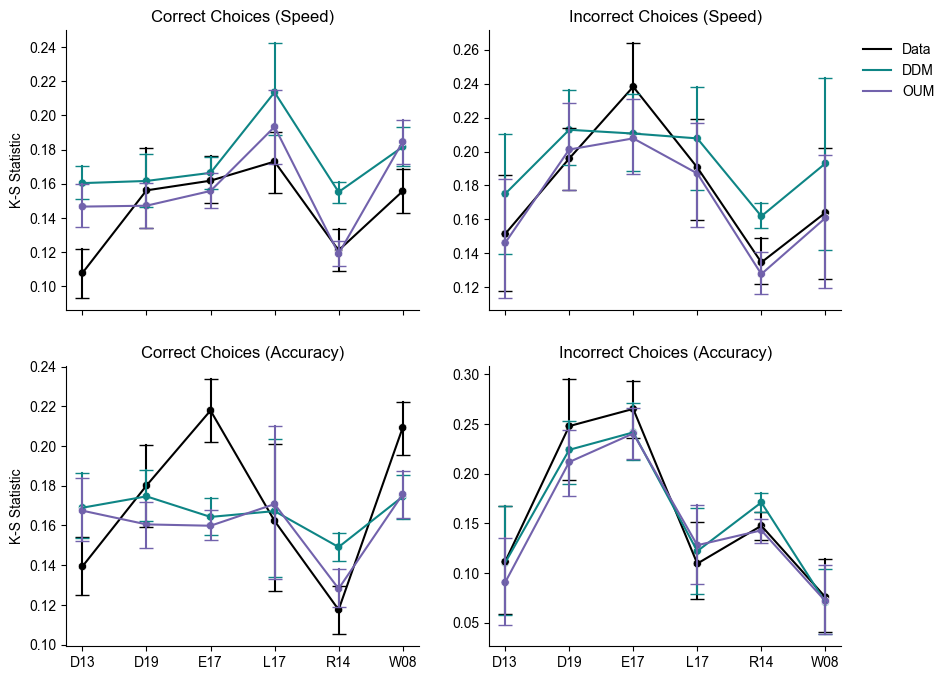

In [7]:
%run SAT_help_functions.ipynb
fig, axes = plt.subplots(2,2,figsize=(10, 8))
plot_09quantile_all_datasets_new(Condition = "cor_s", title = "Correct Choices (Speed)", ax=axes[0,0])
plot_09quantile_all_datasets_new(Condition = "err_s", title = "Incorrect Choices (Speed)", ax=axes[0,1])
plot_09quantile_all_datasets_new(Condition = "cor_a", title = "Correct Choices (Accuracy)", ax=axes[1,0])
plot_09quantile_all_datasets_new(Condition = "err_a", title = "Incorrect Choices (Accuracy)", ax=axes[1,1])

axes[0,0].set_xticks(range(6), [""]*6)
axes[0,1].set_xticks(range(6), [""]*6)

axes[0,1].set_ylabel("")
axes[1,1].set_ylabel("")

axes[0,1].legend(["Data", "DDM", "OUM"], loc = "upper right",bbox_to_anchor=(1.3, 1), frameon=False)

plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42

plt.savefig("/Users/wangjiashun/Desktop/Research_on_SAT/Draft/Supplementary Figures/sup_fig8.pdf")